# Problem Setting

The objective here is to identify from a image that whether the person is wearing a mask or not. Data set has been taken from https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset?resource=download.

The goal is to create a convolutional neural networks that detect the presence of mask.

# Mounting drive and loading necessary libraries

In [1]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input, Activation, Dense, Flatten
import numpy as np
from keras.models import Model, Sequential
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Loading Data Set and processing 

The dataset has three parts: train, valid and test. The image array value has been fixed in size (224,224). 

In [8]:
# data path & pipeline parameters

train_path = '/content/drive/MyDrive/Project/ML 2 Project/Face Mask Dataset/Train'
valid_path = '/content/drive/MyDrive/Project/ML 2 Project/Face Mask Dataset/Validation'
test_path = '/content/drive/MyDrive/Project/ML 2 Project/Face Mask Dataset/Test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

validation_ds = tf.keras.utils.image_dataset_from_directory(valid_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

test_ds = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=False)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


# Data visualization
Some images with their corresponding labels are displayed.

In [14]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


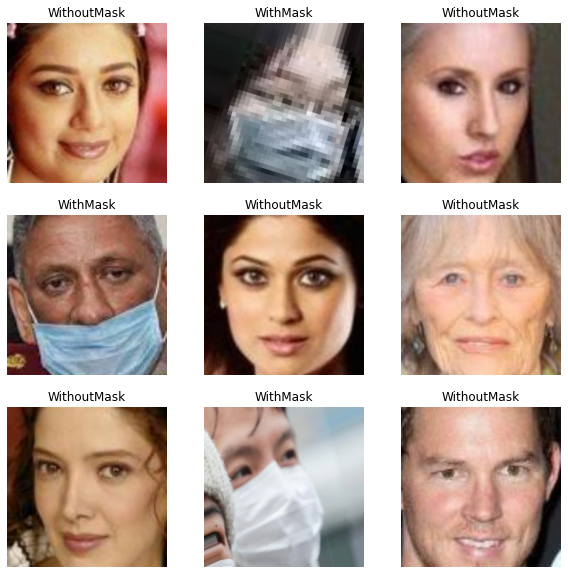

In [ ]:
plt.figure(figsize=(10, 10))  #https://stackoverflow.com/questions/63733998/how-do-you-output-images-from-a-batchdataset-of-images-in-keras
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Text(0.5, 1.0, 'Test data set')

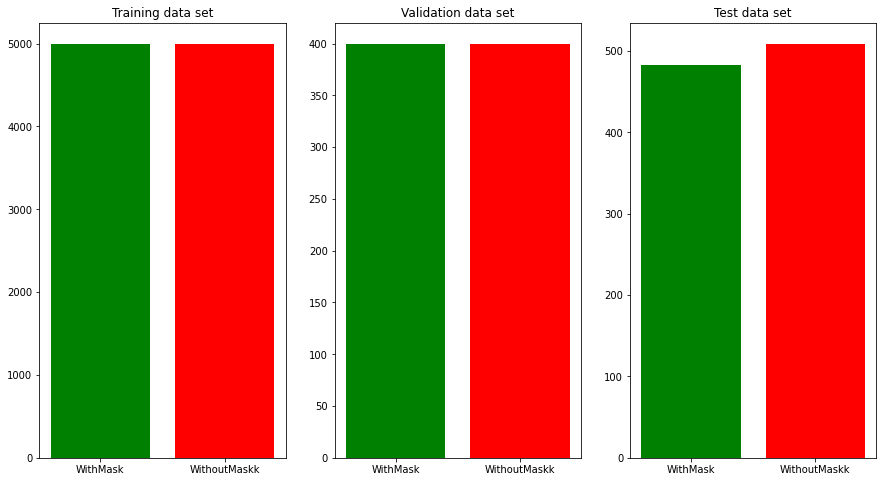

In [ ]:
fig = plt.figure (figsize = (15 , 8))
plt.subplot (1 , 3 , 1)
c = [ 'green', 'red']
plt.bar (x = ["WithMask","WithoutMaskk"] , height = (len (listdir (train_path + "/WithMask")) , 
                                                     len (listdir (train_path + "/WithoutMask"))) , color = c)
plt.title ("Training data set")

plt.subplot (1 , 3 , 2)
plt.bar (x = ["WithMask","WithoutMaskk"] , height = (len (listdir (valid_path + "/WithMask")) , 
                                                     len (listdir (valid_path + "/WithoutMask"))) , color = c)
plt.title ("Validation data set")

plt.subplot (1 , 3 , 3)
plt.bar (x = ["WithMask","WithoutMaskk"] , height = (len (listdir (test_path + "/WithMask")) , 
                                                     len (listdir (test_path + "/WithoutMask"))) , color = c)
plt.title ("Test data set")


From above bar graph, it is evident that the distribution of classes in test, train and validation set is balanced.

# Base Model

The pretained CNN model known as VGG16 available in keras is considered as the baseline model. 

The last layer of the VGG16 model shows that it predicts 1000 categories which  is not suitable for this particular case. Here, the number of prediction class is only two- with mask and without mask. Thus, VGG16 needs to be modified to better suit the problem.  

In [4]:
## run this cell to make sure desired directory is available
%cd /content/drive/MyDrive/Project/ML 2 Project/Models
!pwd


/content/drive/MyDrive/Project/ML 2 Project/Models
/content/drive/MyDrive/Project/ML 2 Project/Models


In [ ]:
## GPU

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/content/drive/.shortcut-targets-by-id/1DeNvAfYJEQLt8rQCISoJWdvPqDZd6wLZ/ML 2 Project/Models
/content/drive/.shortcut-targets-by-id/1DeNvAfYJEQLt8rQCISoJWdvPqDZd6wLZ/ML 2 Project/Models
Found GPU at: /device:GPU:0


In [ ]:
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.vgg16.preprocess_input(x) #preprocessing the data according to the pretrained model vgg16
vgg16_model = VGG16(weights= 'imagenet')
for layer in vgg16_model.layers:
    layer.trainable =  False
x = vgg16_model(x)
classification = Dense(1, activation = 'sigmoid')(x)
vgg = Model(inputs = i, outputs = classification )
vgg.summary()

553467096/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.cast (TFOpLambda)        (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (S  (None, None, None, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)    0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 1)                 1001

In [ ]:
vgg.compile(Adam(learning_rate=0.001) ,metrics=["accuracy"], loss = binary_crossentropy)

In [ ]:
# Training the Base model 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True, verbose=1)

vgglog_csv =callbacks.CSVLogger('vgg_logs.csv', separator=',', append=False)
callback_list_vgg = [earlystopping, vgglog_csv]

with tf.device('/device:GPU:0'): # if gpu is available
  history_vgg = vgg.fit(train_ds,
              epochs = 50,
              validation_data = validation_ds, callbacks = callback_list)

model.save("vgg.h5")

Epoch 1/50
313/313 [==============================] - 50s 145ms/step - loss: 0.6523 - accuracy: 0.8938 - val_loss: 0.6170 - val_accuracy: 0.9300
Epoch 2/50
313/313 [==============================] - 44s 140ms/step - loss: 0.5837 - accuracy: 0.9299 - val_loss: 0.5545 - val_accuracy: 0.9337
Epoch 3/50
313/313 [==============================] - 44s 139ms/step - loss: 0.5255 - accuracy: 0.9341 - val_loss: 0.5014 - val_accuracy: 0.9375
Epoch 4/50
313/313 [==============================] - 44s 140ms/step - loss: 0.4759 - accuracy: 0.9370 - val_loss: 0.4560 - val_accuracy: 0.9375
Epoch 5/50
313/313 [==============================] - 45s 143ms/step - loss: 0.4335 - accuracy: 0.9383 - val_loss: 0.4172 - val_accuracy: 0.9375
Epoch 6/50
313/313 [==============================] - 46s 143ms/step - loss: 0.3972 - accuracy: 0.9402 - val_loss: 0.3838 - val_accuracy: 0.9388
Epoch 7/50
313/313 [==============================] - 44s 140ms/step - loss: 0.3659 - accuracy: 0.9408 - val_loss: 0.3550 - val_ac

# Model      
Here, the target is creating  Customized CNN model, taking the inspiration from VGG6 Structure. 

In [6]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True, verbose=1)

log_csv =callbacks.CSVLogger('model_logs.csv', separator=',', append=False)
callback_list = [earlystopping, log_csv]
num_classes = 2

model = keras.Sequential([
  keras.layers.Rescaling(1./255), # making the range of values {0,1}
  keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #128x128
  keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #64x64
  keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #32x32
  keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #16x16
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(num_classes, activation='sigmoid')
])
model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [10]:
with tf.device('/device:GPU:0'):

  history_model = model.fit(train_ds,
              epochs = 50,
              validation_data = validation_ds,
              callbacks =callback_list)


Epoch 1/50
313/313 [==============================] - 1839s 5s/step - loss: 0.2054 - accuracy: 0.9229 - val_loss: 0.0752 - val_accuracy: 0.9762
Epoch 2/50
313/313 [==============================] - 1596s 5s/step - loss: 0.0679 - accuracy: 0.9763 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 3/50
313/313 [==============================] - 1560s 5s/step - loss: 0.0443 - accuracy: 0.9842 - val_loss: 0.0359 - val_accuracy: 0.9875
Epoch 4/50
313/313 [==============================] - 1556s 5s/step - loss: 0.0330 - accuracy: 0.9879 - val_loss: 0.0237 - val_accuracy: 0.9900
Epoch 5/50
313/313 [==============================] - 1572s 5s/step - loss: 0.0271 - accuracy: 0.9908 - val_loss: 0.0261 - val_accuracy: 0.9937
Epoch 6/50
313/313 [==============================] - 1575s 5s/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 7/50
313/313 [==============================] - 1566s 5s/step - loss: 0.0184 - accuracy: 0.9937 - val_loss: 0.0269 - val_accuracy:

In [11]:
model.save("model.h5")

## Adding dropout and data aumentation layer
The Accuracy of the model is so high. So there is a chance of overfitting. To remedy the situation, some dropout layers are addded as well as some data Augmentation.

In [ ]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
])

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True, verbose=1)

tune_log_csv =callbacks.CSVLogger('tune_model_logs.csv', separator=',', append=False)
callback_list_tune = [earlystopping, tune_log_csv]
num_classes = 2

tune_model = Sequential([
  keras.layers.Rescaling(1./255),
  data_augmentation,
  keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #128x128
  keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  keras.layers.SpatialDropout2D(0.05),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #64x64
  keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  keras.layers.SpatialDropout2D(0.05),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #32x32
  keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  keras.layers.SpatialDropout2D(0.05),
  keras.layers.MaxPooling2D(pool_size=(2,2)), #16x16
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(num_classes, activation='sigmoid')
])

tune_model.compile(optimizer=Adam(learning_rate=0.001),loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])



In [ ]:
with tf.device('/device:GPU:0'):
  tune_history_model = tune_model.fit(train_ds,
              epochs = 50,
              validation_data = validation_ds,
              callbacks =callback_list_tune)
tune_model.save("tune_model1.h5")

Epoch 1/50


313/313 [==============================] - 2015s 6s/step - loss: 0.2459 - accuracy: 0.9110 - val_loss: 0.8611 - val_accuracy: 0.6338
Epoch 2/50
313/313 [==============================] - 1639s 5s/step - loss: 0.1422 - accuracy: 0.9487 - val_loss: 1.6968 - val_accuracy: 0.5525
Epoch 3/50
313/313 [==============================] - 1650s 5s/step - loss: 0.1225 - accuracy: 0.9571 - val_loss: 1.5318 - val_accuracy: 0.5650
Epoch 4/50
313/313 [==============================] - 1638s 5s/step - loss: 0.1052 - accuracy: 0.9641 - val_loss: 1.8167 - val_accuracy: 0.4363
Epoch 4: early stopping


NameError: ignored

# Visualizing the training specs for all three model


In [20]:
# loading all the history
import pandas as pd
vgg_history=np.load('vgg_history.npy',allow_pickle='TRUE').item()
vgg_history = pd.DataFrame(vgg_history)
model_history = pd.read_csv('model_logs.csv')
tune_model_history = pd.read_csv('tune_model_logs.csv')

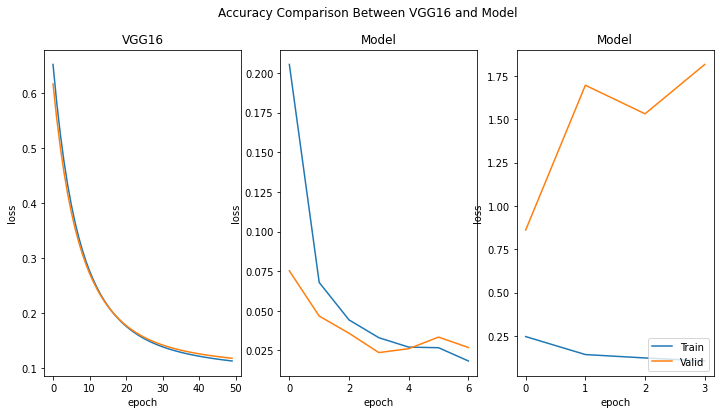

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Accuracy Comparison Between VGG16 and Model')

ax1.plot(vgg_history['loss'], label = 'Train')
ax1.plot(vgg_history['val_loss'], label = 'Valid')
ax1.set_title('VGG16')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

ax2.plot(model_history['loss'], label = 'Train')
ax2.plot(model_history['val_loss'], label = 'Valid')
ax2.set_title('Model')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')

ax3.plot(tune_model_history['loss'], label = 'Train')
ax3.plot(tune_model_history['val_loss'], label = 'Valid')
ax3.set_title('Model')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')

plt.legend( loc='lower right')
plt.show()


# Model Evaluation & prediction


### VGG16


In [ ]:
reconstructed_modelvgg = keras.models.load_model("/content/drive/MyDrive/Project/ML 2 Project/Models/vgg.h5")
e = reconstructed_modelvgg.evaluate(test_ds)

print(f'Test set accuracy: {"{0:.2f}".format(e[1]*100)}%')

31/31 [==============================] - 127s 4s/step - loss: 0.0235 - accuracy: 0.9940
Test set accuracy: 99.40%


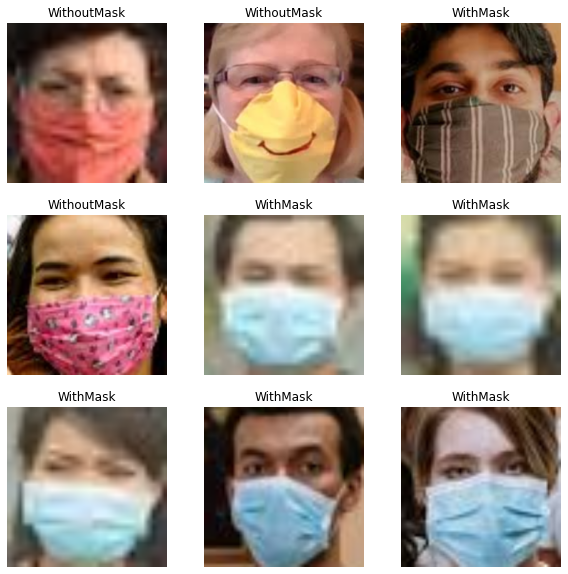

In [ ]:
test_pred =reconstructed_modelvgg.predict(test_ds)
index = np.argmax(test_pred,axis = 1)

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[index[i]])
    plt.axis("off")

### Model

In [12]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Project/ML 2 Project/Models/model.h5")
e = reconstructed_model.evaluate(test_ds)

print(f'Test set accuracy: {"{0:.2f}".format(e[1]*100)}%')

31/31 [==============================] - 163s 5s/step - loss: 0.0647 - accuracy: 0.9829
Test set accuracy: 98.29%


31/31 [==============================] - 43s 1s/step


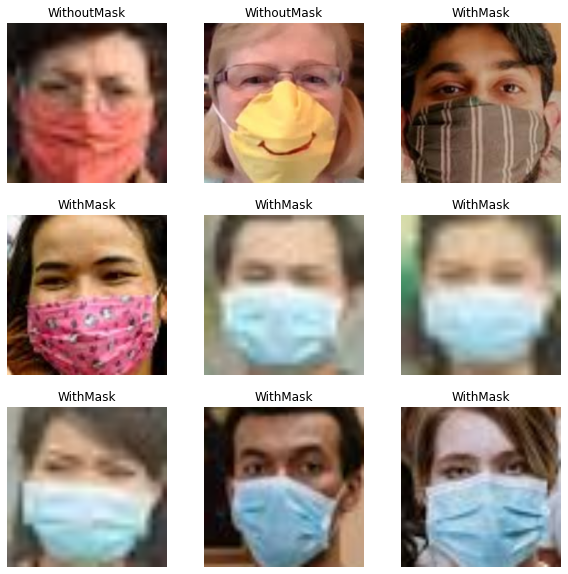

In [15]:
test_pred =reconstructed_model.predict(test_ds)
index = np.argmax(test_pred,axis = 1)

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[index[i]])
    plt.axis("off")

### Tune Model



In [ ]:
reconstructed_model_tune = keras.models.load_model("/content/drive/MyDrive/Project/ML 2 Project/Models/tune_model1.h5")
e = reconstructed_model_tune.evaluate(test_ds)

print(f'Test set accuracy: {"{0:.2f}".format(e[1]*100)}%')

31/31 [==============================] - 45s 1s/step - loss: 0.8584 - accuracy: 0.6290
Test set accuracy: 62.90%


31/31 [==============================] - 42s 1s/step


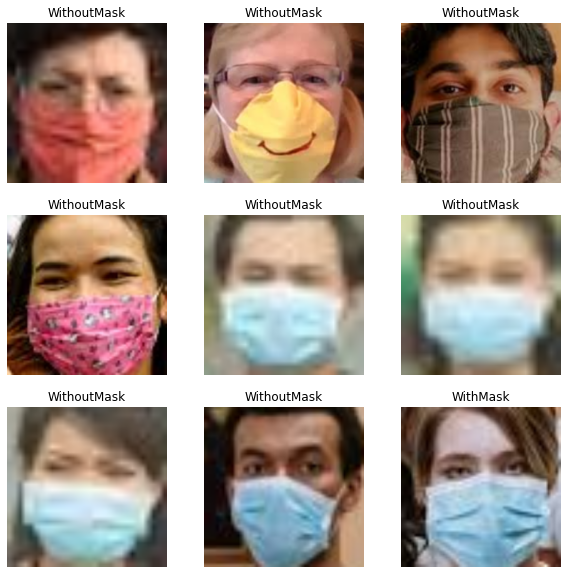

In [ ]:
test_pred =reconstructed_model_tune.predict(test_ds)
index = np.argmax(test_pred,axis = 1)

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[index[i]])
    plt.axis("off")

# Conclusion

Vgg16 model has performed very well regarding the image classification as expected. However, "model" has much less complicated and less parameters to train. Also, it has comparable prediction ability. With computation power keeping in mind, for this particular scenario, "model" is more preferable.  